12/1/17

# Plotting Results from Point Charge Fit

In [1]:
# Import libraries
%matplotlib notebook
# Import libraries
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
from matplotlib.ticker import FuncFormatter
import sys
import CEF_calculations as cef
import time


#Plot Formatting stuff
#########################################################################
#mpl.style.use('default')
import seaborn.apionly as sns
from cycler import cycler
cpal1 = sns.choose_colorbrewer_palette('qualitative')

params = {'text.usetex': False, 'mathtext.fontset': 'stixsans',
          'xtick.direction':'in', 'ytick.direction': 'in',
          'xtick.top': True,'ytick.right': True,
          'font.size': 15, 'axes.prop_cycle': cycler('color',cpal1)}
plt.rcParams.update(params)

def my_formatter(x, pos):
    """Format 0.0 as 0"""
    if x == 0.00: return '{:g}'.format(x)
    else: return x
#########################################################################

/home/allen/anaconda3/lib/python3.6/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


A Jupyter Widget

In [2]:
import pickle

with open('CEF_ND_PC_fitResults.pickle', 'rb') as f:
    Nd3fit, FitVals, NdLigB = pickle.load(f)

In [3]:
# Put the above values for the Debye Waller factor in a dictionary
AtomDisp = {}
AtomDisp['NdMg'] = {}
AtomDisp['NdMg'][6] = 0.0
AtomDisp['NdMg'][100] = 0.045148437500000055
AtomDisp['NdMg'][200] = 0.084953125000000129

AtomDisp['NdZn'] = {}
AtomDisp['NdZn'][6] = 0.0
AtomDisp['NdZn'][100] = 0.045175781250000054
AtomDisp['NdZn'][200] = 0.087765625000000125

AtomDisp['PrMg'] = {}
AtomDisp['PrMg'][6] = 0.0
AtomDisp['PrMg'][100] = 0.045941406250000053
AtomDisp['PrMg'][200] = 0.076910156250000111



# Import Resolution Function

resf150 = np.genfromtxt('./Data/ResolutionFunction/'+
                        'ResFunc150.txt', skip_header=1, unpack=True)
resf80 = np.genfromtxt('./Data/ResolutionFunction/'+
                        'ResFunc80.txt', skip_header=1, unpack=True)
resf40 = np.genfromtxt('/Data/ResolutionFunction/'+
                        'ResFunc40.txt', skip_header=1, unpack=True)

def resfunc(Ei, deltaE):
    if Ei == 150:
        deltaE = np.interp(deltaE, resf150[0], resf150[1])
    elif Ei == 80:
        deltaE =  np.interp(deltaE, resf80[0], resf80[1])
    elif Ei == 40:
        deltaE =  np.interp(deltaE, resf40[0], resf40[1])
    else: print("Ei not in resfunc data.")
    return deltaE



# Test out NeutronSpectrum2D function
Qarray = np.arange(0.1,15,0.1)
Earray = np.arange(5,150,0.5)

def arrayedges(xarray):
    diff = (xarray[1:] - xarray[:-1]) / 2.  # get edges of arrays
    return np.hstack((xarray[0]-diff[0], xarray[:-1]+diff, xarray[-1]+diff[-1]))
Eedges = arrayedges(Earray)
Qedges = arrayedges(Qarray)

In [4]:
### Import Susceptibility data
# Import data
datafile = './Data/'+\
                'Nd3Sb3Mg2O14 MT 1.8 to 300 5000 oe 53.8 mg.dc.dat'
#ImportData
DataA = np.genfromtxt(datafile, delimiter=',', skip_header=31)
Temp = DataA[:,3]
Mag = DataA[:,4]

#Normalize the data
mass = 0.0538 #mass in g of sample
Molarmass = 3*144.242 + 3*121.76 + 2*24.305 + 14*15.9994  #molar mass of sample (g/mol)
field = 5000

NormMag = Mag / mass * Molarmass / 3 / field
Chiminus1 = 1/NormMag  # in emu/Oe/mol
Chiminus1 *= 1/(1.078283e20*10000/6.0221409e23)  # in mu_B/T/ion

[6, 6, 6, 100, 100, 100, 200, 200, 200]
[40, 80, 150, 40, 80, 150, 40, 80, 150]


<IPython.core.display.Javascript object>


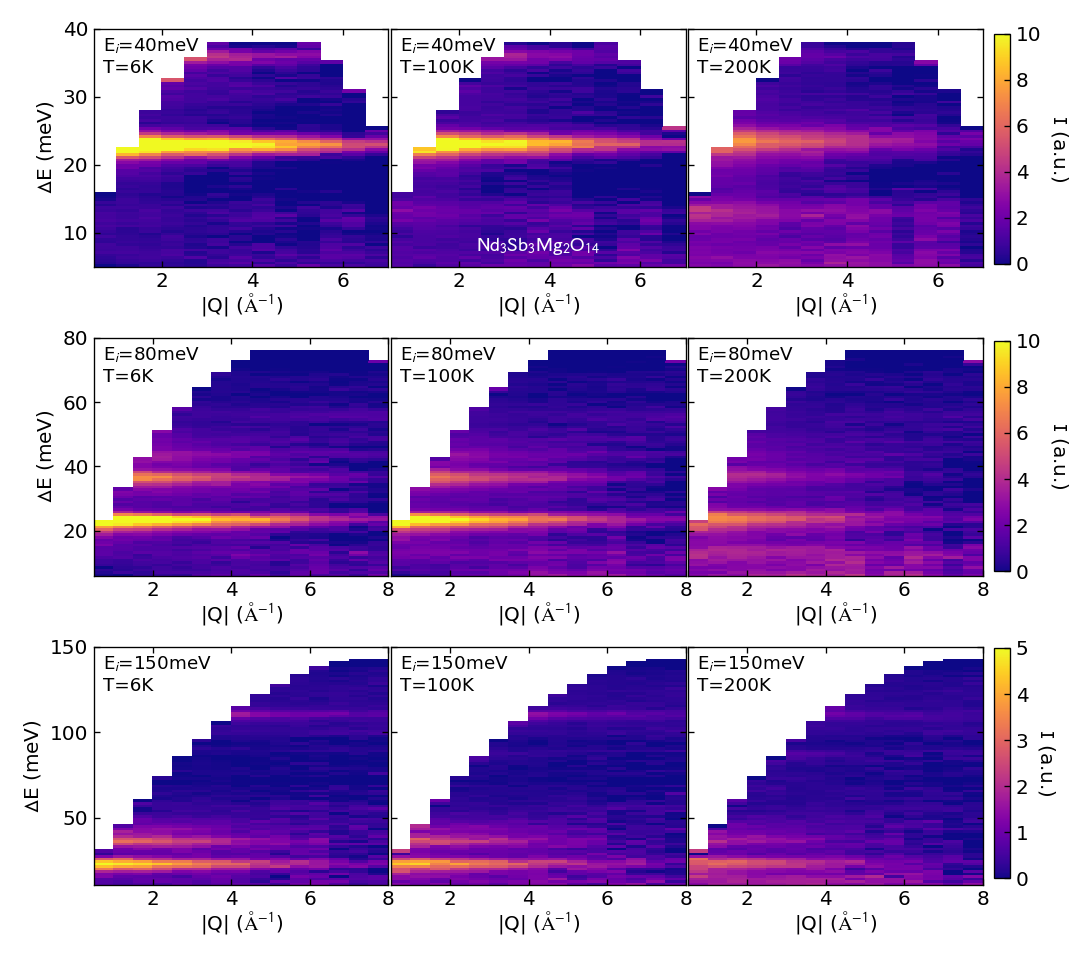

/home/allen/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


In [5]:
# Import data
slicesdirectory = './Data/Slices/'

# Define file names by my naming convention
filenames = []
for T in [6, 100, 200]:
    for E in [40,80,150]:
        filenames.append('NdMg_T'+str(T)+'_E'+str(E)+'_slice.iexy')

data = [cef.importGridfile(slicesdirectory+f) for i,f in enumerate(filenames)]
# # Intensity Error |Q| DeltaE

datatemps = [int(name.split('_')[1][1:]) for name in filenames] # THIS IS PARTICULAR TO MY NAMING CONVENTION
dataengys = [int(name.split('_')[2][1:]) for name in filenames] # THIS IS PARTICULAR TO MY NAMING CONVENTION

print(datatemps)
print(dataengys)

#print data[1][0]



ntemps = len(set(datatemps))
nengys = len(set(dataengys))


plt.rc('font',**{'size':12})
    
f, ax = plt.subplots(3,3, figsize=(9,8))


cax1 = f.add_axes([0.92,0.725,0.015,0.24])
cax2 = f.add_axes([0.92,0.405,0.015,0.24])
cax3 = f.add_axes([0.92,0.085,0.015,0.24])
cax = [cax1, cax2, cax3]

minImaxI = [(0,0.001),(0,0.001),(0,0.0005)]
cmap = 'plasma'
for i in range(nengys):
    minI, maxI = minImaxI[i]
    for j in range(ntemps):
        k = j*ntemps + i
        try: 
            intensity = np.ma.masked_where(np.isnan(data[k]['I']), data[k]['I'])
            ax[i,j].pcolormesh(arrayedges(data[k]['Q']), arrayedges(data[k]['E']), intensity, 
                               rasterized = True, cmap = cmap, vmin = minI, vmax = maxI)
            # Set axis labels
            if j == 0: ax[i,j].set_ylabel('$\Delta$E (meV)')
            else: ax[i,j].yaxis.set_ticklabels([])
            ax[i,j].set_xlabel('|Q| ($\\rm \AA^{-1}$)', labelpad=0)
            # set text in frame
            ax[i,j].text(0.03, 0.97, 'E$_i$='+str(dataengys[k])+'meV'+'\nT='+str(datatemps[k])+'K', fontsize=11,
                        horizontalalignment='left',verticalalignment='top', transform=ax[i,j].transAxes)
        except IndexError:
            break
            
    norm = Normalize(vmin=minI*1e4, vmax=maxI*1e4)
    mappable = cm.ScalarMappable(norm = norm, cmap=cmap)
    mappable.set_array([])
    cb = f.colorbar(mappable, cax[i], cmap =cmap, norm=norm ,orientation='vertical',
                       ticklocation = 'right',drawedges = False)
    cb.solids.set_edgecolor("face")
    #cb.set_ticks(MultipleLocator(0.02))
    cb.formatter.set_powerlimits((-1, 2))
    cb.ax.xaxis.set_label_coords(1.24,0.6)
    #cb.ax.xaxis.set_major_formatter(FormatStrFormatter('%f'))
    cb.set_label('$\\rm I$ (a.u.)', rotation = -90, labelpad = 17)

ax[0,1].text(0.5,0.04,'$\\rm{Nd_3Sb_3Mg_2O_{14}}$', color='w',
    horizontalalignment='center',verticalalignment='bottom', transform=ax[0,1].transAxes)
    
plt.tight_layout()
f.subplots_adjust(wspace=0.01, hspace=0.3, right=0.91)
plt.show()

In [6]:
FitGamma, FitPrefactors = FitVals['gamma'], FitVals['prefacs']
print(FitGamma, FitPrefactors)

Nd3fit.diagonalize()
#print NdLig.B
Nd3fit.printEigenvectors()
Nd3fit.gsExpectation()

[ 2.72729726  3.30244773  5.11796355] [ 0.00309561  0.00291199  0.00146722]

 Eigenvalues 	 Eigenvectors
		-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
0.00000 	|  [ 0.     0.     0.002  0.011 -0.    -0.002 -0.007 -0.031  0.001  0.004
  0.023  0.282 -0.001 -0.013 -0.268  0.07   0.005  0.179 -0.082 -0.022
 -0.083  0.066  0.031  0.17  -0.036 -0.029 -0.271 -0.004  0.018  0.291
  0.007  0.033 -0.21  -0.01  -0.071 -0.087  0.009  0.106  0.224 -0.    -0.112
 -0.408  0.001 -0.     0.55  -0.001  0.    -0.     0.002 -0.     0.001  0.   ]  |
0.00000 	|  [-0.     0.001  0.     0.002 -0.    -0.    -0.001 -0.55   0.     0.001
  0.408 -0.112 -0.    -0.224  0.106 -0.009  0.087 -0.

In [7]:
Coefficients = NdLigB
i=0
for n in range(2,8,2):
    for m in range(0,n+1):
        print(n,m, Coefficients[i])
        i+=1

2 0 0.712926786936
2 1 0.0186270438747
2 2 -0.319263263452
4 0 0.00668475373702
4 1 0.000583117527664
4 2 0.00189296409078
4 3 0.0398793258001
4 4 -0.0046225183649
6 0 7.55419168616e-05
6 1 -3.22146788194e-05
6 2 -4.64022573439e-05
6 3 -0.000538768471656
6 4 6.93371611244e-05
6 5 4.53300471699e-05
6 6 0.000576178364376


3.25
5.25


<IPython.core.display.Javascript object>


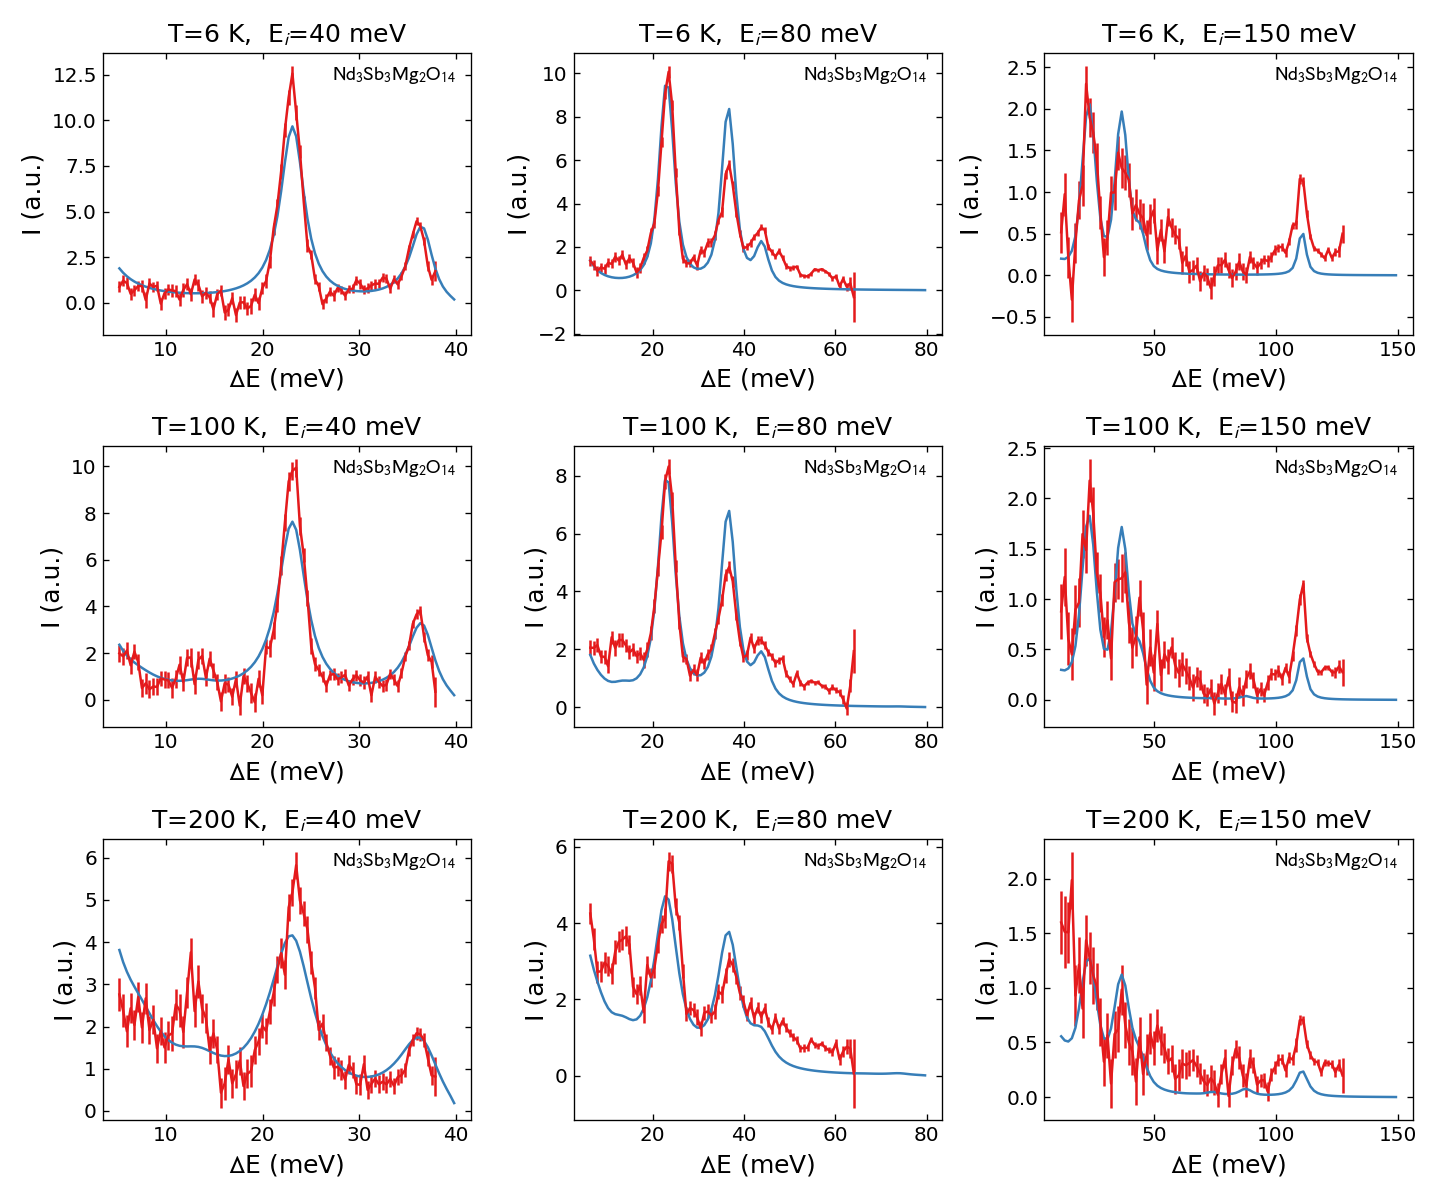

<IPython.core.display.Javascript object>


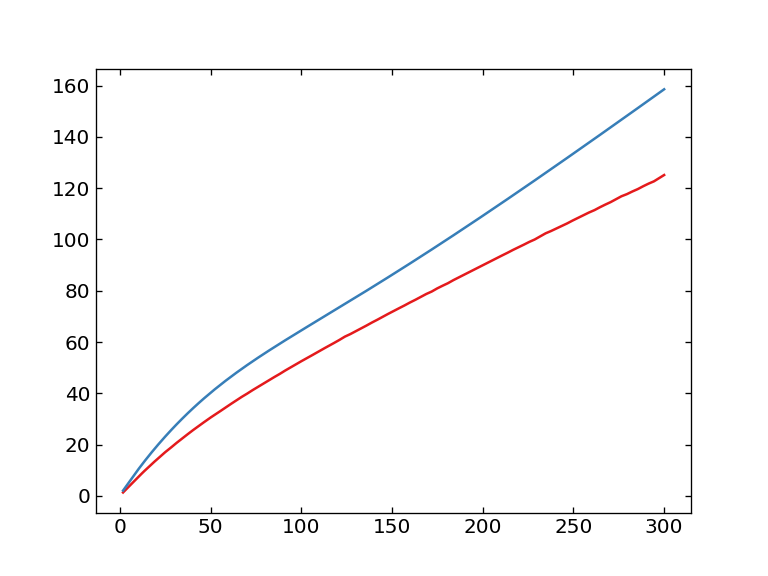

In [8]:
print(data[1]['Q'][5])
print(data[2]['Q'][9])
Qlim = {40:5, 80:5, 150:9}  #indices of the Q cuts that we want to plot


gammas = np.repeat(FitGamma, len(set(datatemps)))
prefc = np.tile(FitPrefactors, len(dataengys))
Nd_intens = []
Nd_fitx = []
for i, t in enumerate(datatemps):
    Nd_intens.append(prefc[i]*Nd3fit.neutronSpectrum2D(Earray=data[i]['E'], Qarray = data[i]['Q'], Temp=t, 
                                                Ei=dataengys[i], ResFunc=lambda de: resfunc(dataengys[i],de), 
                                                gamma=gammas[i],DebyeWaller = AtomDisp['NdMg'][t], Ion = 'Nd3+') )


f, ax = plt.subplots(3,3, figsize=(12,10))

multfac = 10000
for i in range(ntemps):
    for j in range(nengys):
        k = i*ntemps + j
        try: 
            ax[i,j].errorbar(data[k]['E'], multfac*data[k]['I'][:,Qlim[dataengys[k]]], 
                             multfac*data[k]['dI'][:,Qlim[dataengys[k]]])
            ax[i,j].plot(data[k]['E'], multfac*Nd_intens[k][:,Qlim[dataengys[k]]], lw=1.5)
            ax[i,j].set_ylabel('I (a.u.)',fontsize=15)
            ax[i,j].set_xlabel('$\Delta$E (meV)',fontsize=15)
            #ax[i,j].set_ylim(0,0.0006)
            #ax[i,j].legend(frameon=False, fontsize=14)
            ax[i,j].text(0.96,0.96,'$\\rm{Nd_3Sb_3Mg_2O_{14}}$',
                horizontalalignment='right',verticalalignment='top', transform=ax[i,j].transAxes)
            ax[i,j].set_title('T='+str(datatemps[k])+' K,  '+'E$_i$='+str(dataengys[k])+' meV', fontsize=15)
        except IndexError:
            break

plt.tight_layout()
plt.show()


calcsuscep = Nd3fit.susceptibility(Temp, 0.5, 0.001)

plt.figure()
plt.plot(Temp,Chiminus1)
plt.plot(Temp,-1/calcsuscep)